In [1]:
%matplotlib inline
import warnings; warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch
from torch.autograd import Variable

In [2]:
from read_results import read_varnames
varnames = read_varnames("smog_code/smog_Parameters.f90")[0:12]
print(len(varnames), varnames)

12 ['HNO3', 'O', 'RH', 'RCOO2NO2', 'O3', 'HO2', 'RCOO2', 'RCHO', 'RO2', 'NO', 'NO2', 'OH']


# KPP default initial value

In [3]:
df_init = pd.Series(data=1e-8, index=varnames)
df_init['RH'] = 2.0
df_init['RCHO'] = 2.0
df_init['NO'] = 0.5
df_init['NO2'] = 0.1
df_init

HNO3        1.000000e-08
O           1.000000e-08
RH          2.000000e+00
RCOO2NO2    1.000000e-08
O3          1.000000e-08
HO2         1.000000e-08
RCOO2       1.000000e-08
RCHO        2.000000e+00
RO2         1.000000e-08
NO          5.000000e-01
NO2         1.000000e-01
OH          1.000000e-08
dtype: float64

# Integrate forward

In [4]:
import smog_code.kpp4py as kpp

In [5]:
y_history = kpp.forward(df_init.values, 30)
y_history.shape

(12, 30)

In [6]:
df_history = pd.DataFrame(y_history.T, columns=varnames)
df_history.index.name = 'time'
df_history.head()

,HNO3,O,RH,RCOO2NO2,O3,HO2,RCOO2,RCHO,RO2,NO,NO2,OH
time,,,,,,,,,,,,
0,0.011969,0.047323,1.977752,0.033784,0.046263,9.376380e-07,4.809425e-07,1.988463,8.080372e-07,0.166118,0.388129,3.142789e-08
1,0.022814,0.054516,1.966015,0.068263,0.142359,1.834471e-06,6.655699e-07,1.965720,1.441752e-06,0.062340,0.446584,2.289512e-08
2,0.032028,0.052796,1.956457,0.103805,0.270224,3.193612e-06,9.467450e-07,1.939735,2.406003e-06,0.031787,0.432380,2.061908e-08
3,0.040186,0.048891,1.947524,0.139794,0.402131,4.864673e-06,1.303912e-06,1.912677,3.600820e-06,0.019676,0.400344,1.992698e-08
4,0.047505,0.044335,1.938809,0.175995,0.533059,6.894217e-06,1.748860e-06,1.885189,5.061861e-06,0.013483,0.363017,1.973133e-08


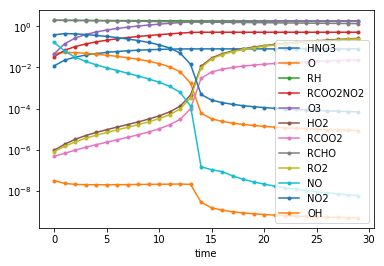

In [7]:
df_history.plot(y=None, logy=True, marker='.')

# Get data range

In [8]:
df_range = df_history.agg(['min', 'max']).T
df_range

,min,max
HNO3,1.196871e-02,8.030713e-02
O,8.425274e-06,5.451626e-02
RH,1.850661e+00,1.977752e+00
RCOO2NO2,3.378443e-02,5.196239e-01
O3,4.626326e-02,1.750093e+00
HO2,9.376380e-07,2.617925e-01
RCOO2,4.809425e-07,2.341105e-02
RCHO,1.358315e+00,1.988463e+00
RO2,8.080372e-07,2.479889e-01
NO,5.853498e-09,1.661183e-01


In [9]:
df_range.to_csv('smog_range.csv')

# Generate random samples within that range

In [10]:
y0_list = np.random.uniform(df_range['min'], df_range['max'], size=(5000, 12) )
y0_list.shape

(5000, 12)

In [11]:
%%time
y1_list = kpp.onestep(y0_list.T).T

CPU times: user 448 ms, sys: 6.53 ms, total: 454 ms
Wall time: 459 ms


In [12]:
y1_list.min(axis=0) # make sure no negative value

array([  1.24225899e-02,   4.83092533e-06,   1.76676510e+00,
         6.36402423e-02,   9.57009183e-02,   4.58453043e-06,
         1.47614026e-06,   1.19624716e+00,   3.72545192e-06,
         3.84942581e-09,   3.95575182e-05,   1.28732144e-10])

# Normalize data

In [13]:
normalizer = StandardScaler()
normalizer.fit(y0_list)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
X_train = normalizer.transform(y0_list)
X_train.shape

(5000, 12)

In [15]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 1.20622806,  0.76510955,  1.08306733,  1.1839305 ,  1.03759816,
        0.77302507,  0.3689744 ,  1.00718606,  0.56173056,  0.04543872,
        0.75829264,  1.18175151])

# Fit ANN

In [16]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [17]:
H1, H2 = 30, 30

model = torch.nn.Sequential(
    torch.nn.Linear(12, H1),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 12)
)

In [18]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

for t in range(3000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.03292034938931465
400 0.006658074911683798
600 0.003680205438286066
800 0.00228567561134696
1000 0.0016691390192136168
1200 0.0013406443176791072
1400 0.0011888745939359069
1600 0.0010962777305394411
1800 0.0011572845978662372
2000 0.0008998924749903381
2200 0.0007989921723492444
2400 0.0008486927254125476
2600 0.0007161701214499772
2800 0.0007242973078973591
3000 0.0006734388880431652


In [19]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 2.71 ms, sys: 571 µs, total: 3.28 ms
Wall time: 1.79 ms


In [20]:
y_pred_numpy.shape

(5000, 12)

In [21]:
r2_score(y_pred_numpy, Y_train)

0.98695315713238518

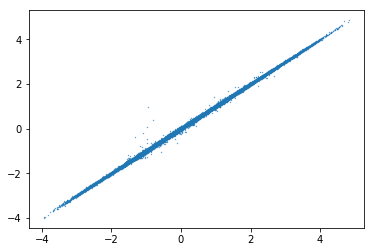

In [22]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)

# Make new prediction

In [23]:
y0_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, 12) )

In [24]:
y1_test = kpp.onestep(y0_test.T).T

In [25]:
X_test = normalizer.transform(y0_test)
Y_test = normalizer.transform(y1_test)

In [26]:
Y_test.shape

(5000, 12)

In [27]:
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()
y_test_pred.shape

(5000, 12)

In [28]:
r2_score(y_test_pred, Y_test)

0.98646025480960098

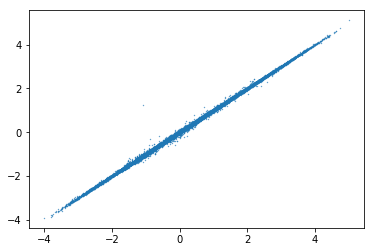

In [29]:
plt.scatter(y_test_pred, Y_test, s=0.1)

# Integrate forward in time

## Reference result

In [30]:
y_start = y0_test[0]
y_history_true = kpp.forward(y_start, 10).T

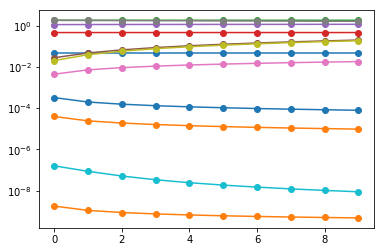

In [31]:
plt.plot(y_history_true, '-o')
plt.yscale('log')

## In normalized space

In [32]:
y_history_true_normed = normalizer.transform(y_history_true)

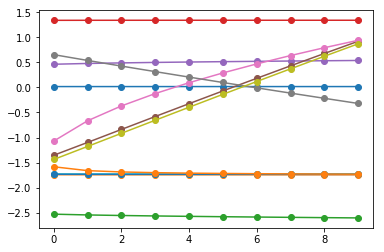

In [33]:
plt.plot(y_history_true_normed, '-o');

## ANN prediction

In [34]:
y_start_normed = normalizer.transform(y_start.reshape(1,-1))

In [35]:
y_history_pred = []

v_torch_temp = Variable(torch.from_numpy(y_start_normed).type(torch.FloatTensor))

for t in range(10):
    v_torch_temp = model(v_torch_temp)
    y_history_pred.append(v_torch_temp.data.numpy().ravel())
    
y_history_pred = np.array(y_history_pred)

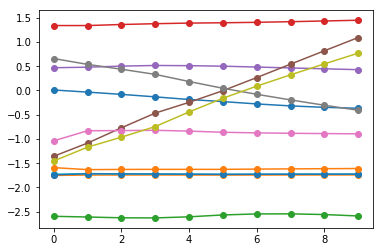

In [36]:
plt.plot(y_history_pred, '-o');

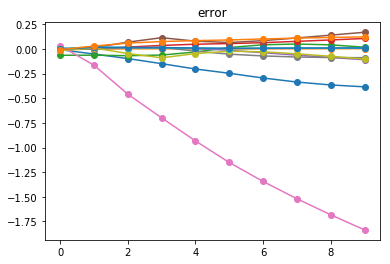

In [37]:
plt.plot(y_history_pred - y_history_true_normed, '-o');
#plt.ylim(y_history_true_normed.min(), y_history_true_normed.max())
plt.title('error')

# Predict multiple time series

In [38]:
%%time
n_step = 10

y_end = y0_test.copy() # will be the final concentration
for i in range(n_step):
    y_end = kpp.onestep(y_end.T).T

y_end = normalizer.transform(y_end)

CPU times: user 1.14 s, sys: 27.2 ms, total: 1.17 s
Wall time: 1.1 s


In [39]:
y_end.shape

(5000, 12)

In [40]:
%%time
v_torch_temp = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))

for t in range(n_step):
    v_torch_temp = model(v_torch_temp)
    
y_end_pred = v_torch_temp.data.numpy()

CPU times: user 43.2 ms, sys: 12.1 ms, total: 55.3 ms
Wall time: 29.5 ms


In [41]:
y_end_pred.shape

(5000, 12)

In [42]:
r2_score(y_end_pred.ravel(), y_end.ravel())

0.90210450066872705

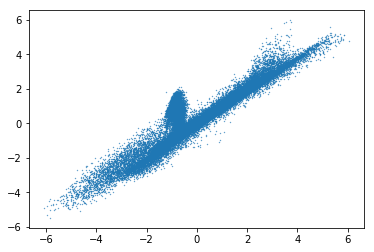

In [43]:
plt.scatter(y_end_pred.ravel(), y_end.ravel(), s=0.1)